**Table of contents**<a id='toc0_'></a>    
- [LangGraph Multi-Agent Supervisor](#toc1_)    
- [LangChain MCP Adapters](#toc2_)    
  - [Server](#toc2_1_)    
- [Connect to WhatsApp](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[LangGraph Multi-Agent Supervisor](#toc0_)

In [1]:
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

model = ChatOpenAI(model="gpt-4o")

# Create specialized agents

def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, math_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "For current events, use research_agent. "
        "For math problems, use math_agent."
    )
)

# Compile and run
app = workflow.compile()
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "what's the combined headcount of the FAANG companies in 2024?"
        }
    ]
})

In [2]:
result

{'messages': [HumanMessage(content="what's the combined headcount of the FAANG companies in 2024?", additional_kwargs={}, response_metadata={}, id='cd127337-1ea7-4017-b8c6-49cc0e541dac'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lJO7fB9tRJw2FhBoesBpvd9I', 'function': {'arguments': '{}', 'name': 'transfer_to_research_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 112, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'id': 'chatcmpl-BIhVlJZHroAdUdJbEsL08RFUQPxOC', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-23587dbc-426f-4e85-9415-b8fd1936791a-0', tool_calls=[{'name': 'transfer_to_research_expert', '

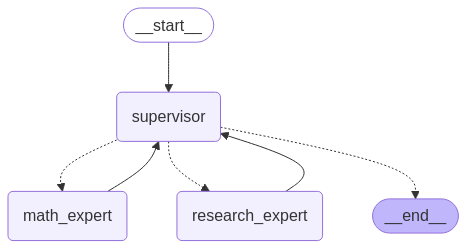

In [3]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# <a id='toc2_'></a>[LangChain MCP Adapters](#toc0_)

In [9]:
!pip install langchain-mcp-adapters

## <a id='toc2_1_'></a>[Server](#toc0_)
First, let's create an MCP server that can add and multiply numbers.

```python
# math_server.py
from mcp.server.fastmcp import FastMCP

mcp = FastMCP("Math")

@mcp.tool()
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

@mcp.tool()
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b

if __name__ == "__main__":
    mcp.run(transport="stdio")
```

In [27]:
# Create server parameters for stdio connection
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client

from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent

from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o")

server_params = StdioServerParameters(
    command="python",
    # Make sure to update to the full absolute path to your math_server.py file
    args=["math_server.py"],
)

async with stdio_client(server_params) as (read, write):
    async with ClientSession(read, write) as session:
        # Initialize the connection
        await session.initialize()

        # Get tools
        tools = await load_mcp_tools(session)

        # Create and run the agent
        agent = create_react_agent(model, tools)
        agent_response = await agent.ainvoke({"messages": "what's (3 + 10) x 12?"})

In [28]:
agent_response

{'messages': [HumanMessage(content="what's (3 + 10) x 12?", additional_kwargs={}, response_metadata={}, id='a888a30c-6d4d-47dc-86db-a45e770bf857'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4LsD5w5shnktu7ekZO41lyHT', 'function': {'arguments': '{"a": 3, "b": 10}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_22ZMbcNjgoxn63rUFDpYd6Wk', 'function': {'arguments': '{"a": 13, "b": 12}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 77, 'total_tokens': 128, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'id': 'chatcmpl-BIkVvkCpoI4e9MpyEzPEd2WlhhZ3b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d8c06b7c-267b-4c2d-9fd8-935dcfbf3

In [29]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent

from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o")

async with MultiServerMCPClient(
    {
        "math": {
            "command": "python",
            # Make sure to update to the full absolute path to your math_server.py file
            "args": ["math_server.py"],
            "transport": "stdio",
        },
        "weather": {
            # make sure you start your weather server on port 8000
            "url": "http://localhost:8000/sse",
            "transport": "sse",
        }
    }
) as client:
    agent = create_react_agent(model, client.get_tools())
    math_response = await agent.ainvoke({"messages": "what's (3 + 5) x 12?"})
    weather_response = await agent.ainvoke({"messages": "what is the weather in nyc?"})

In [30]:
math_response

{'messages': [HumanMessage(content="what's (3 + 5) x 12?", additional_kwargs={}, response_metadata={}, id='e527619f-76df-4549-882f-df2231758603'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JIdbJaVyQNoeitnoHkMeppiT', 'function': {'arguments': '{"a": 3, "b": 5}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_g0mdsXnom9bZUdG9CLbcl0iR', 'function': {'arguments': '{"a": 8, "b": 12}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 96, 'total_tokens': 147, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'id': 'chatcmpl-BIkWUdK1oJdpHDxgs1Okl2TRtzidI', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cf4f1b3c-859b-410f-bf47-6f9ef81cb949

In [31]:
weather_response

{'messages': [HumanMessage(content='what is the weather in nyc?', additional_kwargs={}, response_metadata={}, id='b51c33a2-62fe-44e2-9acf-3a3c037c66dd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_D55ccXnDDS6wMdjJ6iRwLJqr', 'function': {'arguments': '{"location":"new york city"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 92, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'id': 'chatcmpl-BIkWWxiGTi9mafElKKolFmpIGdupg', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4339a18f-bfb4-4b54-9b47-ce7cd14dc77a-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'new york city'}, 'id': 'call_D55ccXnDDS

# <a id='toc3_'></a>[Connect to WhatsApp](#toc0_)

In [1]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent

from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

async with MultiServerMCPClient(
    {
        "whatsapp": {
            "command": "/Users/nmlemus/.local/bin/uv",
            "args": [
                "--directory",
                "/Users/nmlemus/projects/mcp/whatsapp-mcp/whatsapp-mcp-server",
                "run",
                "main.py",
            ],
            "transport": "stdio",
        },
        "mcp-obsidian": {
            "command": "npx",
            "args": [
                "-y",
                "@smithery/cli@latest",
                "run",
                "mcp-obsidian",
                "--config",
                '"{\\"vaultPath\\":\\"/Users/nmlemus/projects/notes\\"}"',
            ],
        },
        "docker-mcp": {
            "command": "npx",
            "args": ["-y", "@smithery/cli@latest", "run", "docker-mcp"],
        },
    }
) as client:
    agent = create_react_agent(model, client.get_tools())
    print(client.get_tools())
    # math_response = await agent.ainvoke({"messages": "what's (3 + 5) x 12?"})
    weather_response = await agent.ainvoke(
        {
            "messages": "Deploy a wordpress server using docker compose",
        }
    )

[StructuredTool(name='search_contacts', description='Search WhatsApp contacts by name or phone number.\n    \n    Args:\n        query: Search term to match against contact names or phone numbers\n    ', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'search_contactsArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x10e4487c0>), StructuredTool(name='list_chats', description='Get WhatsApp chats matching specified criteria.\n    \n    Args:\n        query: Optional search term to filter chats by name or JID\n        limit: Maximum number of chats to return (default 20)\n        page: Page number for pagination (default 0)\n        include_last_message: Whether to include the last message in each chat (default True)\n        sort_by: Field to sort results by, either "last_active" or "name" (default "last_active")\n    ', args_schem

CancelledError: 

In [48]:
math_response

{'messages': [HumanMessage(content="what's (3 + 5) x 12?", additional_kwargs={}, response_metadata={}, id='ff8c09ee-7789-4d9e-8a70-a0f70b7d4a35'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M1DyRWRPFv1S4goQ8yqXxF8z', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 225, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'id': 'chatcmpl-BIkkgWhWj2lV6NfbJB3syZheksupW', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6df07191-d28b-494a-8c44-93315fa64e8a-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_M1DyRWRPFv1S4goQ8yqXxF8z', 'type': 'tool_call'}], usage_meta

In [21]:
print(weather_response['messages'][-1].content)

Yes, you have a note on "topic modeling". Here's a summary of its contents:

**Topic Modeling:**  
Topic modeling is an unsupervised machine learning technique used to discover and identify the abstract topics that appear in a collection of documents or text data. It's often used in natural language processing (NLP) to organize, understand, and summarize large sets of textual information. The method involves text preprocessing (tokenization, stop-word removal, stemming/lemmatization), and the output is a set of topics each represented by a distribution of words, and each document represented as a distribution of topics.

**Example Use Case:**  
For instance, in a dataset with customer reviews for a product, topic modeling can uncover common themes like "product quality," "shipping experience," or "customer support."

**BERTopic:**  
BERTopic is highlighted as a technique leveraging Transformers and c-TF-IDF to create dense clusters that allow for easily interpretable topics, while main

In [10]:
await agent.ainvoke(
        {
            "messages": "get last chats from +50763994214 and 50763644604"
        }
    )

{'messages': [HumanMessage(content='get last chats from +50763994214 and 50763644604', additional_kwargs={}, response_metadata={}, id='bac33171-3acd-41a9-ba2b-0e72d3087a37'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5dFk0YGdUEO9HIle5gAHU0UD', 'function': {'arguments': '{"sender_phone_number": "50763994214"}', 'name': 'get_direct_chat_by_contact'}, 'type': 'function'}, {'id': 'call_GavkaFoOwbI8V3ectSpUoSs4', 'function': {'arguments': '{"sender_phone_number": "50763644604"}', 'name': 'get_direct_chat_by_contact'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 669, 'total_tokens': 730, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'id': 'chatcmpl-BJOYy4BcMChDS